# Load MNIST handwritten digits dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
import numpy as np
# Plot train and test loss
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[..., None] / 255.
X_test = X_test[..., None] / 255.
x = X_train[:100]
y = y_train[:100]

print(X_train.shape, y_train.shape)

(60000, 28, 28, 1) (60000,)


# Define our autoencoder model

In [2]:
from functools import reduce
from typing import Iterable
from keras import layers as L
from keras import Model


def encoder(input_dim: Iterable[int], latent_dim: int = 8, noise_std=0.05, dropout=0.2) -> Model:
    inputs = L.Input(shape=input_dim)
    x = L.Flatten()(inputs)
    x = L.GaussianNoise(noise_std)(x)
    x = L.BatchNormalization()(x)

    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim * 16, activation='relu')(x)
    x = L.LayerNormalization()(x)
    
    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim, activation='linear')(x)
    x = L.LayerNormalization()(x)
    
    model = Model(inputs=inputs, outputs=x, name='encoder')
    return model


def decoder(latent_dim: int = 8, output_dim: Iterable[int] = (28, 28, 1), dropout=0.2, noise_std=0.02) -> Model:
    output_dim_size: int = reduce(lambda x, y: x * y, output_dim)
    inputs = L.Input(shape=(latent_dim,))
    
    x = L.GaussianNoise(noise_std)(inputs)
    
    x = L.Dense(latent_dim * 16, activation='relu')(x)
    x = L.Dropout(dropout)(x)
    x = L.LayerNormalization()(x)

    x = L.Dense(output_dim_size, activation='sigmoid')(x)
    x = L.Reshape(output_dim)(x)
    
    model = Model(inputs=inputs, outputs=x, name='decoder')
    return model


# encoder(input_dim=(28, 28, 1))(x[None, ...]).shape

In [3]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from functools import reduce
from typing import Iterable


def encoder(latent_dim: int = 8):
    inputs = L.Input(shape=(28, 28, 1))
    x = inputs
    
    x = L.GaussianNoise(0.02)(x)
    
    x = L.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2), padding='same')(x)
    x = L.Dropout(0.1)(x)
    
    x = L.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2), padding='same')(x)
    x = L.Dropout(0.1)(x)

    # (7, 7, 4) -> (, 196)
    x = L.Flatten()(x)
    x = L.Dense(latent_dim, activation="relu")(x)
    x = L.LayerNormalization()(x)
    
    model = Model(inputs=inputs, outputs=x, name='encoder')
    return model


def decoder(latent_dim: int = 8):
    inputs = L.Input(shape=(latent_dim,))
    x = inputs
    
    x = L.Dense(7 * 7 * 4, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x = L.Reshape((7, 7, 4))(x)

    x = L.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = L.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

    # x = L.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = L.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # cropped = x[..., 2:-2, 2:-2, :]
    cropped = x
    model = Model(inputs=inputs, outputs=cropped, name='decoder')
    return model

# z = encoder(input_dim=(28, 28, 1))(x)
# _x = decoder(latent_dim=8, output_dim=(28, 28, 1))(z)

z = encoder()(x)
_x = decoder()(z)

z.shape, _x.shape

2024-01-24 17:39:51.718427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-24 17:39:51.718444: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-01-24 17:39:51.718448: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-01-24 17:39:51.718470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 17:39:51.718481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(TensorShape([100, 8]), TensorShape([100, 28, 28, 1]))

In [4]:
latent_dim: int = 10
image_dim: Iterable[int] = (28, 28, 1)

e = encoder(latent_dim=latent_dim)
d = decoder(latent_dim=latent_dim)

z = e(x)
x_hat = d(z)

print("Encoder: {} -> {}".format(x.shape, z.shape))
print("Decoder: {} -> {}".format(z.shape, x_hat.shape))

Encoder: (100, 28, 28, 1) -> (100, 10)
Decoder: (100, 10) -> (100, 28, 28, 1)


# Train our autoencoder model

In [5]:
inputs = L.Input(shape=image_dim)
z = e(inputs)
outputs = d(z)

autoencoder = Model(inputs=inputs, outputs=outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 10)                8502      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         23277     
                                                                 
Total params: 31779 (124.14 KB)
Trainable params: 31779 (124.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
history = autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=5,
    validation_data=(X_test, X_test),
)

Epoch 1/20


2024-01-24 17:39:52.690959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 16s 8ms/step - loss: 0.1043 - val_loss: 0.0680
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0697 - val_loss: 0.0636
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0670 - val_loss: 0.0629
Epoch 4/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0657 - val_loss: 0.0613
Epoch 5/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0648 - val_loss: 0.0606
Epoch 6/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0641 - val_loss: 0.0605
Epoch 7/20
1112/1875 [================>.............] - ETA: 5s - loss: 0.0635

KeyboardInterrupt: 

NameError: name 'history' is not defined

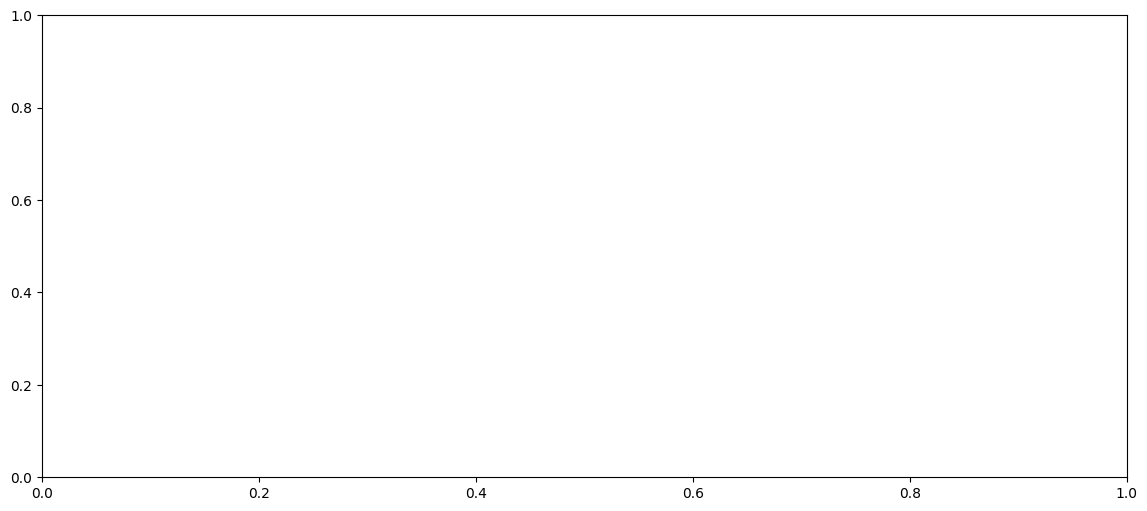

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')

# log scale
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# We can now easily train a naive classifier on the latent space representations

In [14]:
z_train = e.predict(X_train)
z_test = e.predict(X_test)
z = e.predict(x)

z_train.shape

4/4 [==============================] - 0s 2ms/step


(60000, 10)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

for cls in (LogisticRegression, KNeighborsClassifier, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis):
    name = cls.__name__
    
    classifier = cls().fit(z_train, y_train)
    roc_auc = roc_auc_score(y_test, classifier.predict_proba(z_test), multi_class='ovr')
    
    print("{}: {:.4f}".format(name, roc_auc))

LogisticRegression: 0.9855
KNeighborsClassifier: 0.9750
LinearDiscriminantAnalysis: 0.9812
QuadraticDiscriminantAnalysis: 0.9886


# 

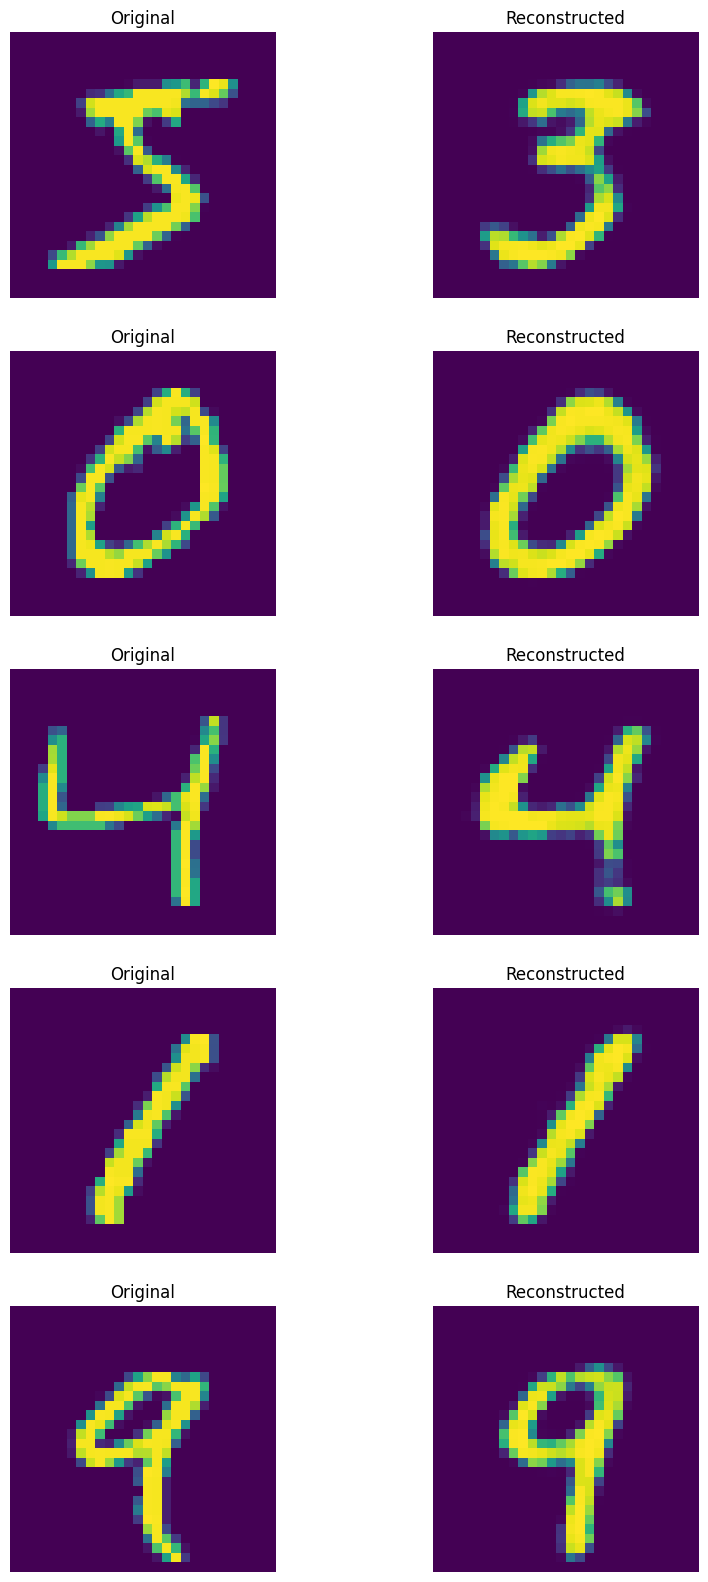

In [10]:
n_images: int = 5

# Show them side by side
fig, ax = plt.subplots(n_images, 2, figsize=(10, 20))

x_hat = autoencoder.predict(X_train[:n_images], verbose=0)

for i in range(n_images):
    label = y_train[i]
    ax[i, 0].imshow(X_train[i, ..., 0], cmap='viridis')
    ax[i, 1].imshow(x_hat[i, ..., 0], cmap='viridis')

    ax[i, 0].set_title('Original')
    ax[i, 1].set_title('Reconstructed')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

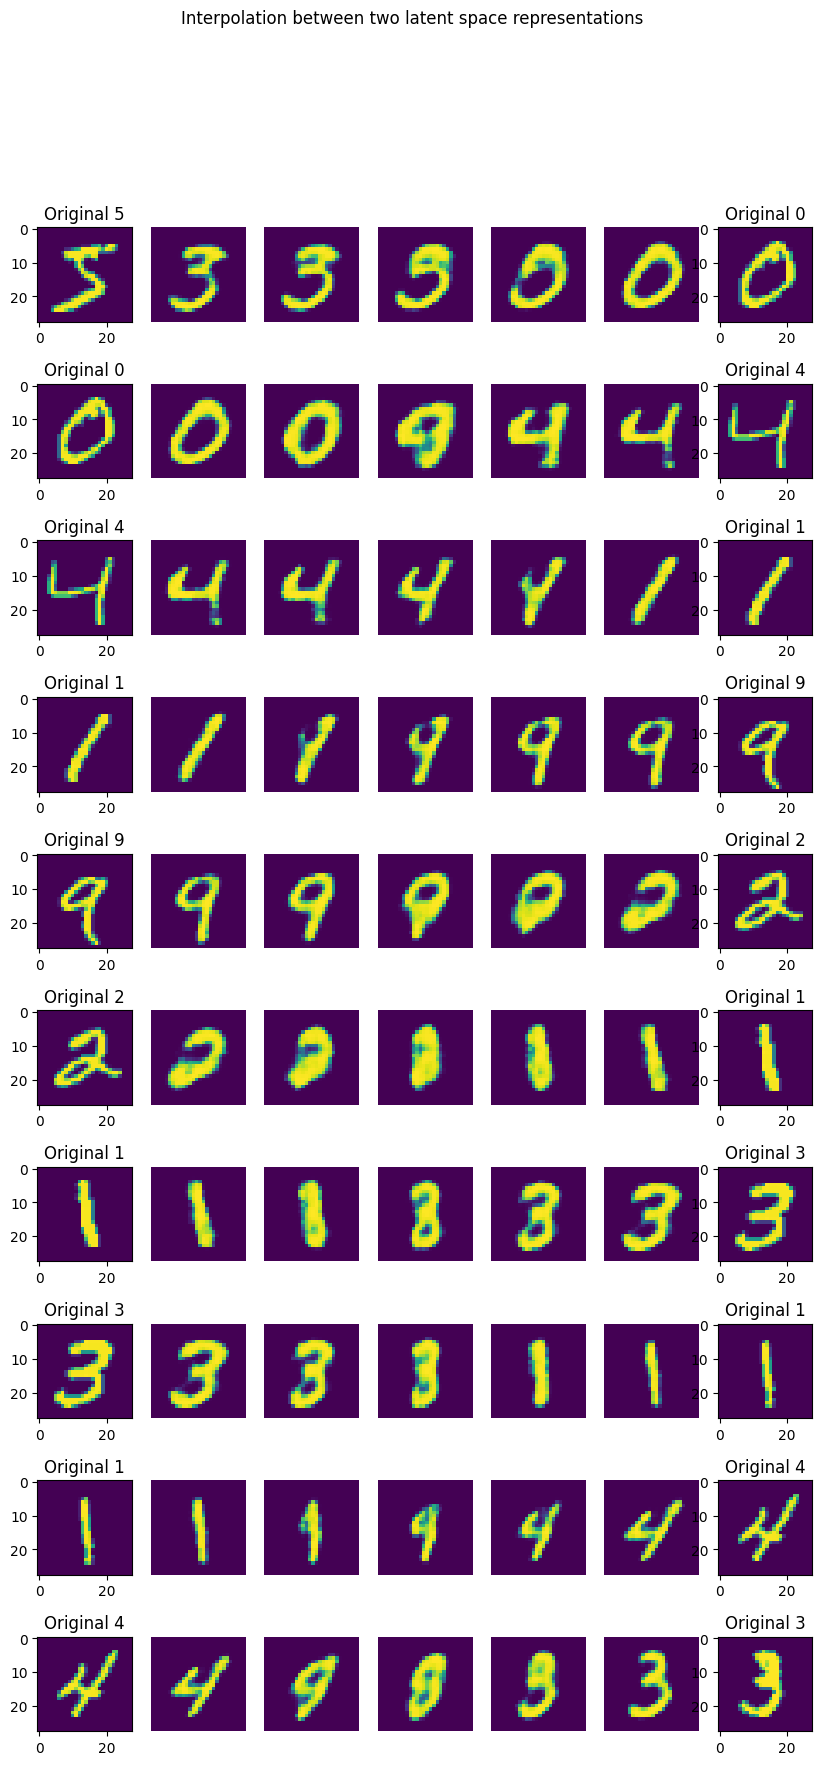

In [16]:
n_steps: int = 5
n_images: int = 10

fig, axs = plt.subplots(n_images, n_steps + 2, figsize=(10, 20))

for idx in range(n_images):
    a_original = x[idx]
    a_label = y[idx]
    b_original = x[idx + 1]
    b_label = y[idx + 1]
    a = z[idx]
    b = z[idx + 1]
    z_hat = a + (b - a) * np.linspace(0, 1, n_steps)[:, None]
    x_hat = d.predict(z_hat, verbose=0)
    
    axs[idx, 0].imshow(a_original[..., 0], cmap='viridis')
    axs[idx, 0].set_title('Original {}'.format(a_label))

    for i in range(n_steps):
        axs[idx, i + 1].imshow(x_hat[i, ..., 0], cmap='viridis')
        axs[idx, i + 1].axis('off')
        
    axs[idx, -1].imshow(b_original[..., 0], cmap='viridis')
    axs[idx, -1].set_title('Original {}'.format(b_label))

_ = fig.suptitle('Interpolation between two latent space representations')

# Visualizing the Principal Components of the Latent Space

In [17]:
from sklearn.decomposition import PCA
n_pca_components: int = 10

pca = PCA(n_components=n_pca_components).fit(z_train)

pca

PCA(n_components=10)

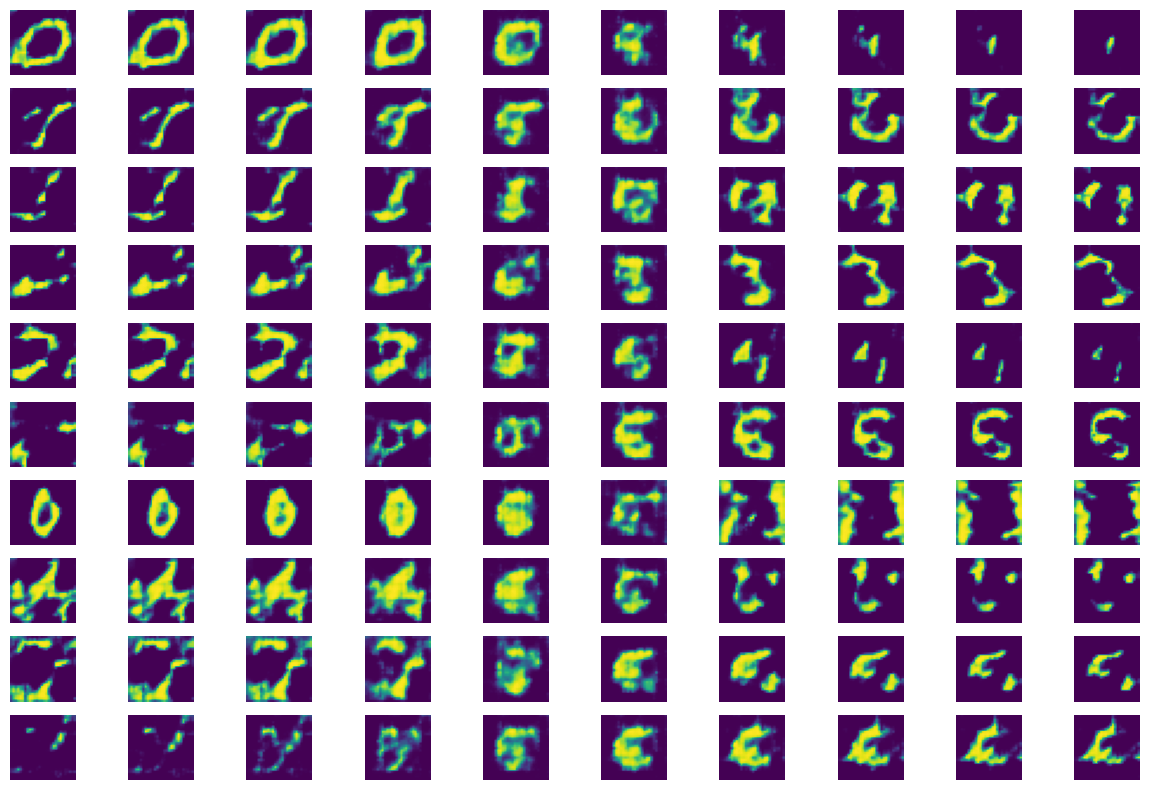

In [18]:
# z_0 = z_train[1]
z_0 = np.zeros_like(z_train[1])
n_steps: int = 10
t: float = 5

fig, axs = plt.subplots(n_pca_components, n_steps, figsize=(15, 10))

for pc_idx in range(n_pca_components):
    pc_a = pca.components_[pc_idx]

    z_hat = z_0 + pc_a * np.linspace(-t, t, n_steps)[:, None]
    x_hat = d.predict(z_hat, verbose=0)

    for i in range(n_steps):
        axs[pc_idx, i].imshow(x_hat[i, ..., 0], cmap='viridis')
        axs[pc_idx, i].axis('off')

1/1 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'Mean 2')

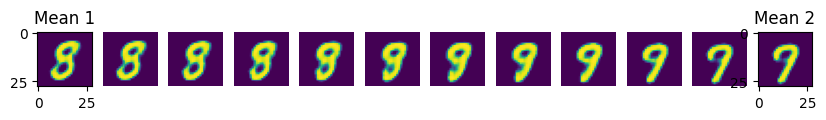

In [20]:
from sklearn.cluster import KMeans

n_means = 10

kmeans = KMeans(n_clusters=n_means).fit(z_train)

# And morph from mean 1 to mean 2
z_mean_1 = kmeans.cluster_centers_[0]
z_mean_2 = kmeans.cluster_centers_[1]
z_hat = z_mean_1 + (z_mean_2 - z_mean_1) * np.linspace(0, 1, n_steps)[:, None]
x_hat = d.predict(z_hat, verbose=0)

fig, axs = plt.subplots(1, n_steps + 2, figsize=(10, 2))

axs[0].imshow(d.predict(z_mean_1[None, ...])[0, ..., 0], cmap='viridis')
axs[0].set_title('Mean 1')

for i in range(n_steps):
    axs[i + 1].imshow(x_hat[i, ..., 0], cmap='viridis')
    axs[i + 1].axis('off')

axs[-1].imshow(d.predict(z_mean_2[None, ...])[0, ..., 0], cmap='viridis')
axs[-1].set_title('Mean 2')

# Scatter plot with the images as markers

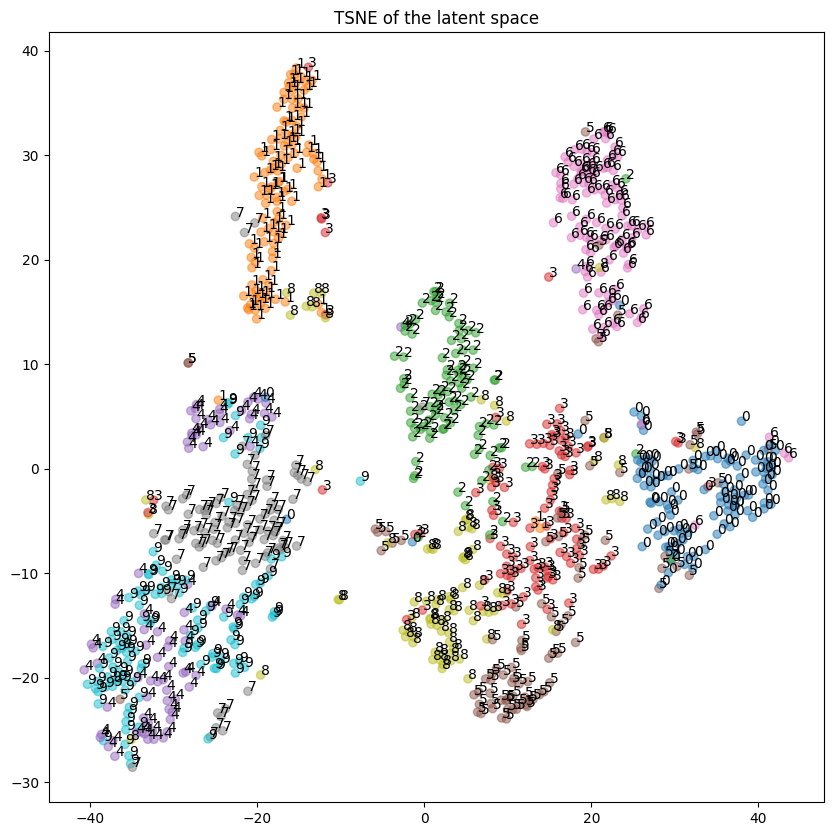

In [23]:
from sklearn.manifold import TSNE

n_samples: int = 1000

idxs = np.random.choice(np.arange(len(z_test)), size=n_samples, replace=False)
t = TSNE(n_components=2).fit_transform(z_test[idxs])

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(t[:, 0], t[:, 1], c=y_test[idxs], cmap='tab10', alpha=0.5)
ax.set_title('TSNE of the latent space')

# And plot the labels
for i in range(n_samples):
    ax.annotate(str(y_test[idxs][i]), (t[i, 0], t[i, 1]))

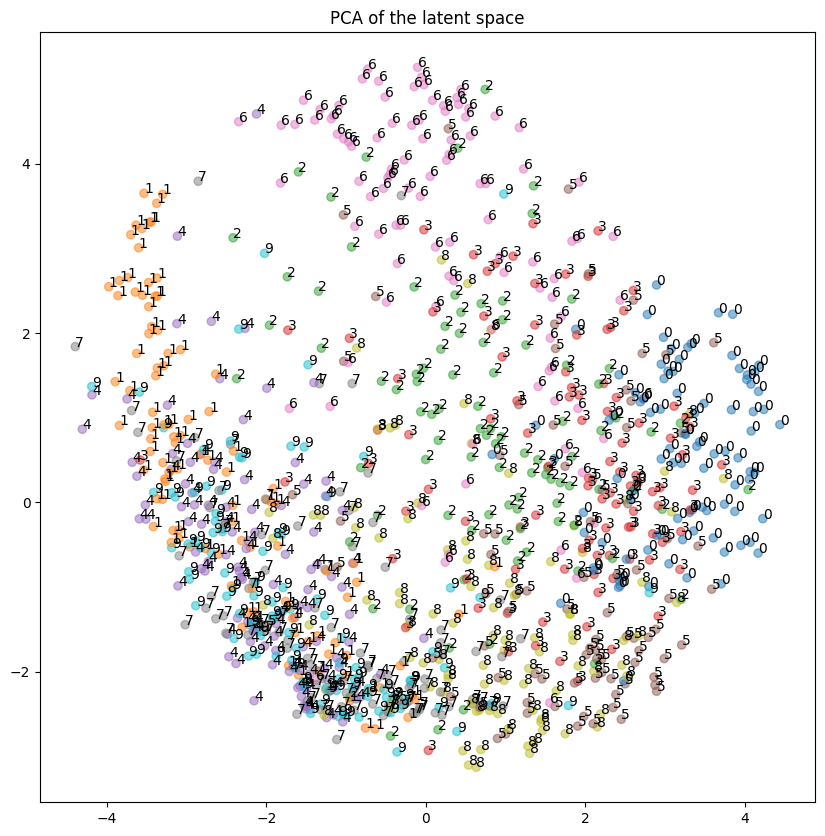

In [24]:
# And the same with PCA
from sklearn.decomposition import PCA

n_samples: int = 1000

idxs = np.random.choice(np.arange(len(z_test)), size=n_samples, replace=False)

pca = PCA(n_components=2).fit_transform(z_test[idxs])

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(pca[:, 0], pca[:, 1], c=y_test[idxs], cmap='tab10', alpha=0.5)
ax.set_title('PCA of the latent space')

# And plot the labels
for i in range(n_samples):
    ax.annotate(str(y_test[idxs][i]), (pca[i, 0], pca[i, 1]))